In [29]:
from Utility05_Bayesian import *
from bayes_opt import BayesianOptimization
from tiramisu_net import *

In [30]:
n_classes

2

In [31]:
Model_set_id=1

In [32]:
def make_di_path(path_name):
    try:
        os.mkdir(path_name)
    except OSError:
        print ("Creation of the directory %s failed" % path_name)
    else:
        print ("Successfully created the directory %s " % path_name)    

In [33]:
path_name="case_study_models"+'\\'+'Model set-'+str(Model_set_id).zfill(2)
make_di_path(path_name)
Model_dir=path_name+'\\'

Creation of the directory case_study_models\Model set-01 failed


In [34]:
import os, shutil
folder = Model_dir
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

## Deep learning architecture

### BaySeg Trainer

In [35]:
def Seg_trainer(Model_set_id):    

    timeNow=datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S")
    timeprint=datetime.datetime.now().strftime("%Y-%m-%d-%H:%M:%S")
    model_filename_save=Model_dir+WeightMethod+' Model'+'.h5'
    verbose1=1
    verbose2=0
    
    optimizer='Nadam'
    hyp_a=1e-4   # lr
    hyp_b=0.0004   # decay
    L2_C=1e-6
    hyp_c='null'
    hyp_d='null'
    
    #--------------------------------------------------------------------------------------------------------#
    # Find class weight factors based on WeightMethod
    if WeightMethod=='UW':
        class_weights_ones=np.ones(class_weights_freq.shape)
        class_weights_mat_train=gen_weight_mat(Y_train,class_weights_ones)
        class_weights_mat_val=gen_weight_mat(Y_val,class_weights_ones)
    elif WeightMethod=='MFW':
        class_weights_mat_train=gen_weight_mat(Y_train,class_weights_freq)
        class_weights_mat_val=gen_weight_mat(Y_val,class_weights_freq)
    else:
        print('Invalid Weighting Method')

    #--------------------------------------------------------------------------------------------------------#

    Seg_model=Tiramisu(L2_C,
                       input_shape=input_shape,
                       n_classes = 2,
                       n_filters_first_conv = 16,
                       n_pool = 3,
                       growth_rate = 16 ,
                       n_layers_per_block = [2,2,2,5,2,2,2],
                       dropout_p = 0.2)
    # Train the model
    Seg_model_hist,Seg_model=BaySDS_fit(Seg_model,X_train,Y_train_cat,X_val,Y_val_cat,verbose1,
                                class_weights_mat_train,class_weights_mat_val,
                                n_epoch,batch_size,model_filename_save,
                                patience,optimizer,hyp_a,hyp_b,hyp_c,hyp_d)
        
    prd_set,crack_prob_set,prc_bin,rec_bin,f1_bin,PRCurve_bin,mean_prc_bin,_,_,_=Models_eval06B(model_filename_save,
                                                                      model_specs,X_val,Y_val)

    print('============================================================================')
    print(timeprint)
    print('Precision= ',np.round(prc_bin[1]*100,2), ' Recall= ',np.round(rec_bin[1]*100,2),
          ' F1-Score= ',np.round(f1_bin[1]*100,2), ' MPA= ',np.round(mean_prc_bin*100,2))
    print('')
    
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    plt.subplots_adjust(wspace=0.2, hspace=None)
    
    ax[0].plot(Seg_model_hist.history['val_loss'],'r')
    ax[0].plot(Seg_model_hist.history['loss'],'b')
    ax[0].plot(np.argmin(Seg_model_hist.history['loss']),np.amin(Seg_model_hist.history['loss']),'xb')
    ax[0].plot(np.argmin(Seg_model_hist.history['val_loss']),np.amin(Seg_model_hist.history['val_loss']),'xr')
    
    ax[0].set_title('Loss-Model at:'+str(timeprint))
    ax[0].set_ylabel('loss')
    ax[0].set_xlabel('epoch')
    
    ax[1].plot(Seg_model_hist.history['val_acc'],'r')
    ax[1].plot(Seg_model_hist.history['acc'],'b')
    ax[1].plot(np.argmax(Seg_model_hist.history['acc']),np.amax(Seg_model_hist.history['acc']),'xb')
    ax[1].plot(np.argmax(Seg_model_hist.history['val_acc']),np.amax(Seg_model_hist.history['val_acc']),'xr')
    
    ax[1].set_title('Acc-Model at:'+str(timeprint))
    ax[1].set_ylabel('acc')
    ax[1].set_xlabel('epoch')
    
      
    ax[0].set_ylim(bottom=0)
    ax[1].set_ylim(0.0,1)
    # Based on experience!
        
    ax[0].legend(['training', 'validation'], loc='upper left')
    ax[1].legend(['training', 'validation'], loc='upper left')
        
    # Clean up GPU
    del Seg_model
    del Seg_model_hist
    K.clear_session()
    
    return mean_prc_bin

# Run model

In [36]:
n_epoch = 400
batch_size = 2
patience=10

In [37]:
WeightMethod='MFW'
model_specs='MFW-MAP'

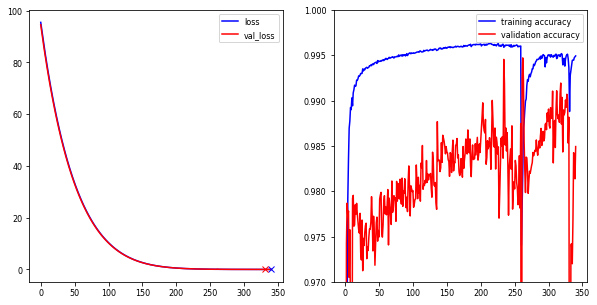

F:\ProgramData\Anaconda3\envs\P3.5\lib\site-packages\numpy\core\_methods.py:143: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)


2020-05-05-12:29:55
Precision=  99.1  Recall=  76.28  F1-Score=  61.65  MPA=  0



0

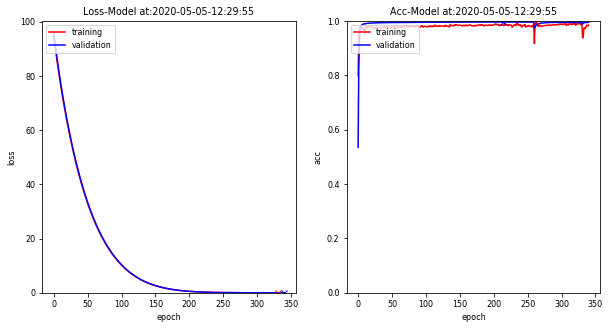

In [38]:
Seg_trainer(Model_set_id)

## Test and evaluation

In [39]:
B_MFW_MAP_model_filename=Model_dir+WeightMethod+' Model'+'.h5'

In [40]:
PRD_test,prc_bin_test,rec_bin_test,f1_bin_test,IoU_bin_test,_,_,SoftmaxStd_test,SoftmaxMean_test,entropy_test=Models_eval06B(B_MFW_MAP_model_filename,model_specs,X_test,Y_test)

F:\ProgramData\Anaconda3\envs\P3.5\lib\site-packages\numpy\core\_methods.py:143: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)


In [41]:
IoU_bin_test

[0.9879445354904127, 0.6510461626998808]

In [42]:
np.mean(IoU_bin_test)

0.8194953490951468

In [43]:
f1_bin_test

array([0.99393571, 0.78864683])

In [44]:
np.mean(f1_bin_test)

0.8912912728353687

In [45]:
prc_bin_test

array([0.99976503, 0.6554514 ])

In [46]:
np.mean(prc_bin_test)

0.8276082174932563

In [47]:
rec_bin_test

array([0.98817398, 0.98978221])

In [48]:
np.mean(rec_bin_test)

0.9889780942011706

In [ ]:
import pandas as pd
df_test_metrics=pd.DataFrame({'prc_bin_test':prc_bin_test,
                              'rec_bin_test':rec_bin_test,
                              'f1_bin_test':f1_bin_test,
                              'IoU_bin_test':IoU_bin_test})
df_test_metrics.to_excel('../standard_do.xlsx')
df_test_metrics

In [49]:
PRD_val,prc_bin_val,rec_bin_val,f1_bin_val,IoU_bin_val,_,_,SoftmaxStd_val,SoftmaxMean_val,entropy_val=Models_eval06B(B_MFW_MAP_model_filename,model_specs,X_val,Y_val)

F:\ProgramData\Anaconda3\envs\P3.5\lib\site-packages\numpy\core\_methods.py:143: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)


In [57]:
IoU_bin_val

[0.9879304502460255, 0.6165127159309021]

In [50]:
np.mean(IoU_bin_val)

0.8022215830884638

In [58]:
f1_bin_val

array([0.99392859, 0.76276878])

In [51]:
np.mean(f1_bin_val)

0.8783486826516722

In [59]:
prc_bin_val

array([0.99982137, 0.61998975])

In [52]:
np.mean(prc_bin_val)

0.8099055567145445

In [53]:
rec_bin_val

array([0.98810486, 0.99098535])

In [54]:
np.mean(rec_bin_val)

0.989545101832253

In [55]:
# batch_file_name='SRG_train.npz'
# np.savez_compressed(batch_file_name, PRD_train=PRD_train, SoftmaxStd_train=SoftmaxStd_train,
#                     SoftmaxMean_train=SoftmaxMean_train, entropy_train=entropy_train)

# batch_file_name='SRG_val.npz'
# np.savez_compressed(batch_file_name, PRD_val=PRD_val, SoftmaxStd_val=SoftmaxStd_val,
#                     SoftmaxMean_val=SoftmaxMean_val, entropy_val=entropy_val)

batch_file_name='standard_do_test.npz'
np.savez_compressed(batch_file_name, PRD_test=PRD_test, SoftmaxStd_test=SoftmaxStd_test,
                    SoftmaxMean_test=SoftmaxMean_test, entropy_test=entropy_test)

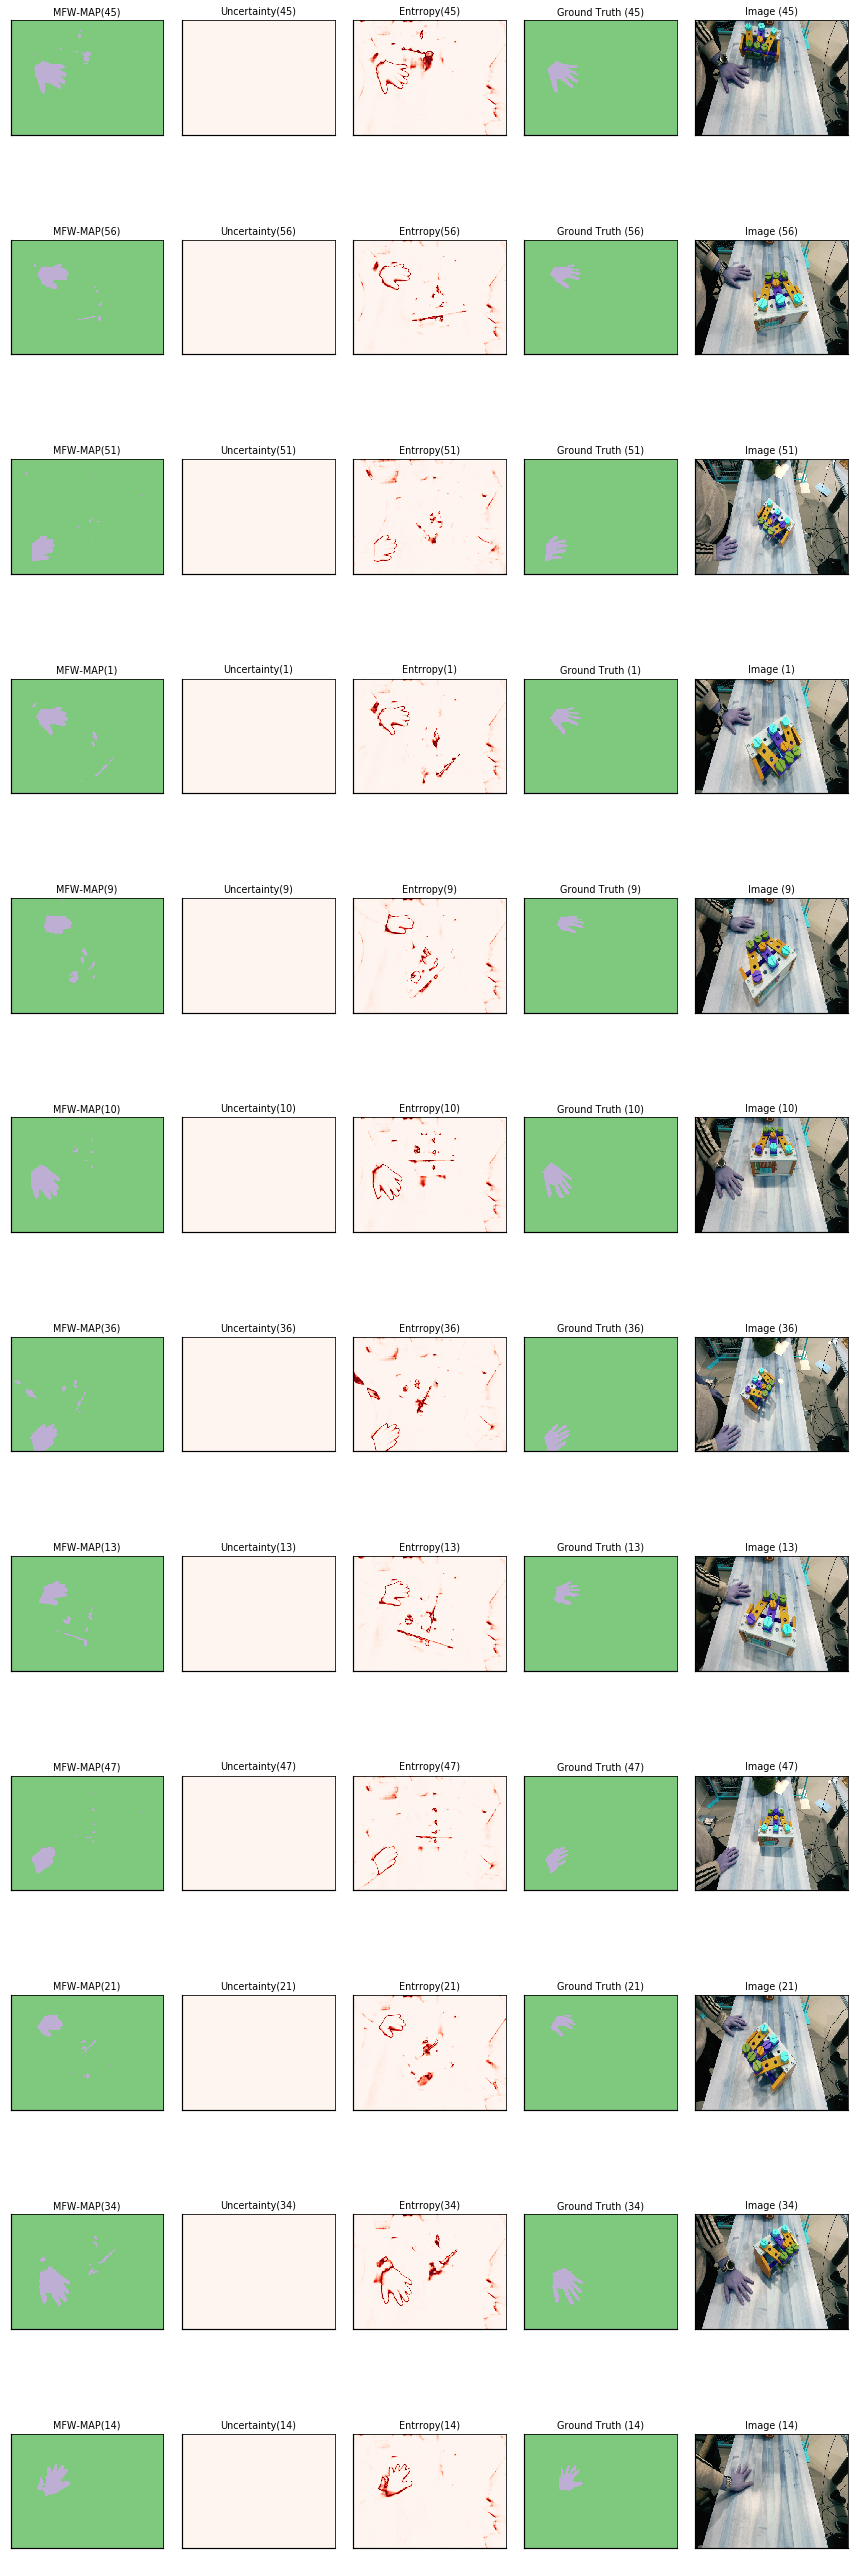

In [56]:
indc_plot=np.arange(0,12,1)

X_set=X_test[indc_plot,:,:,:]
Y_set=Y_test[indc_plot,:,:]
Set_indc=indc_plot
nSet=X_set.shape[0]
plt.rcParams["font.size"] = 8
cmap_id='Dark2'

cmap=plt.cm.Accent

cmap_u=plt.cm.Reds

fig,axes=plt.subplots(nSet,2+3,figsize=(15,4*nSet))

plt.subplots_adjust(wspace=0.12, hspace=0.12)

mean_var=np.mean(SoftmaxStd_test,axis=-1)
for i in range(2+3):
    for j in range(nSet):
        axes[j,i].spines['top'].set_visible(1.2)
        axes[j,i].spines['right'].set_visible(1.2)
        axes[j,i].spines['bottom'].set_linewidth(1.2)
        axes[j,i].spines['left'].set_linewidth(1.2)
        axes[j,i].set_yticklabels([])
        axes[j,i].set_xticklabels([])
        axes[j,i].tick_params(bottom=False, left=False)
        
for j in range(nSet):
    XL_image_id=str(test_indc[Set_indc[j]]+1)
    im_gt=axes[j,-2].imshow(Y_set[j,:,:],cmap=cmap,vmin=0,vmax=7)
    axes[j,-2].set_title('Ground Truth '+'('+XL_image_id+')')
    
    axes[j,-1].imshow(X_set[j,:,:,:])
    axes[j,-1].set_title('Image '+'('+XL_image_id+')')
    
    im_1=axes[j,1].imshow(mean_var[indc_plot[j],:,:],cmap=cmap_u)
    axes[j,1].set_title('Uncertainty'+'('+XL_image_id+')')
    
    im_2=axes[j,2].imshow(entropy_test[indc_plot[j],:,:],cmap=cmap_u)
    axes[j,2].set_title('Entrropy'+'('+XL_image_id+')')
    
    im_prd=axes[j,0].imshow(PRD_test[indc_plot[j],:,:],cmap=cmap,vmin=0,vmax=7)
    axes[j,0].set_title(model_specs+'('+XL_image_id+')')
    
#     cax1=plt.colorbar(im_1,ax=axes[j,1],fraction=0.040, pad=0.04)
#     cax2=plt.colorbar(im_2,ax=axes[j,2],fraction=0.040, pad=0.04)
#     cax3=plt.colorbar(im_prd,ax=axes[j,0],fraction=0.040, pad=0.04)
#     cax4=plt.colorbar(im_gt,ax=axes[j,-2],fraction=0.040, pad=0.04)
    # cax.set_ticks(np.arange(0, 17, 1))
    
# plt.tight_layout(pad=0.01, h_pad=0.01, w_pad=0.01)            

plot_save_name='BO-Test-Img-Select-Uncertainty'
# fig.savefig(plot_save_name+str(cmap_id)+'.png',dpi=200, pad_inches=0.1,bbox_inches='tight')    
fig.savefig(plot_save_name+str(cmap_id)+'.svg',dpi=300, pad_inches=0.1,bbox_inches='tight')   